In [ ]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import os

from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import base64
from bs4 import BeautifulSoup

import schedule
import time
from datetime import datetime

# Define the SCOPES. If modifying it, delete the token.pickle file.
SCOPES = ['https://www.googleapis.com/auth/gmail.readonly']

In [2]:
df = pd.read_csv("spam.csv", encoding='latin1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
df.drop(columns=["Unnamed: 2","Unnamed: 3","Unnamed: 4"],inplace = True)

In [5]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.rename(columns = {"v1":"label","v2":"text"},inplace= True)
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.isnull().sum()

label    0
text     0
dtype: int64

In [8]:
df.duplicated().sum()

403

In [9]:
df = df.drop_duplicates(keep = "first")

In [10]:
df.duplicated().sum()

0

In [11]:
df["label"].value_counts()

label
ham     4516
spam     653
Name: count, dtype: int64

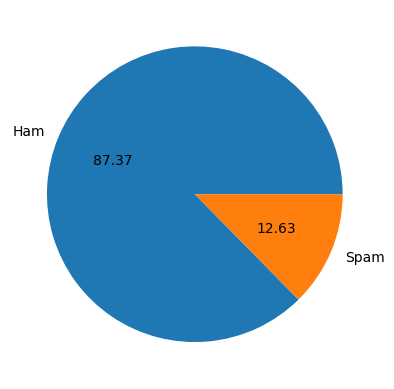

In [12]:
plt.pie(df['label'].value_counts(),autopct='%0.02f',labels=['Ham','Spam'])

plt.show()

In [13]:
df["num_of_characters"]=df["text"].apply(len)

In [14]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [15]:
df["num_of_words"] = df["text"].apply(lambda x:len(nltk.word_tokenize(x)))
df["num_of_sentence"] = df["text"].apply(lambda x:len(nltk.sent_tokenize(x)))

In [16]:
df.head()

,label,text,num_of_characters,num_of_words,num_of_sentence
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [17]:
df[["num_of_characters","num_of_words","num_of_sentence"]].describe()

,num_of_characters,num_of_words,num_of_sentence
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [18]:
# For Ham
df[df["label"]== 'ham' ][["num_of_characters","num_of_words","num_of_sentence"]].describe()

,num_of_characters,num_of_words,num_of_sentence
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [19]:
# For Spam
df[df["label"]== 'spam' ][["num_of_characters","num_of_words","num_of_sentence"]].describe()

,num_of_characters,num_of_words,num_of_sentence
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


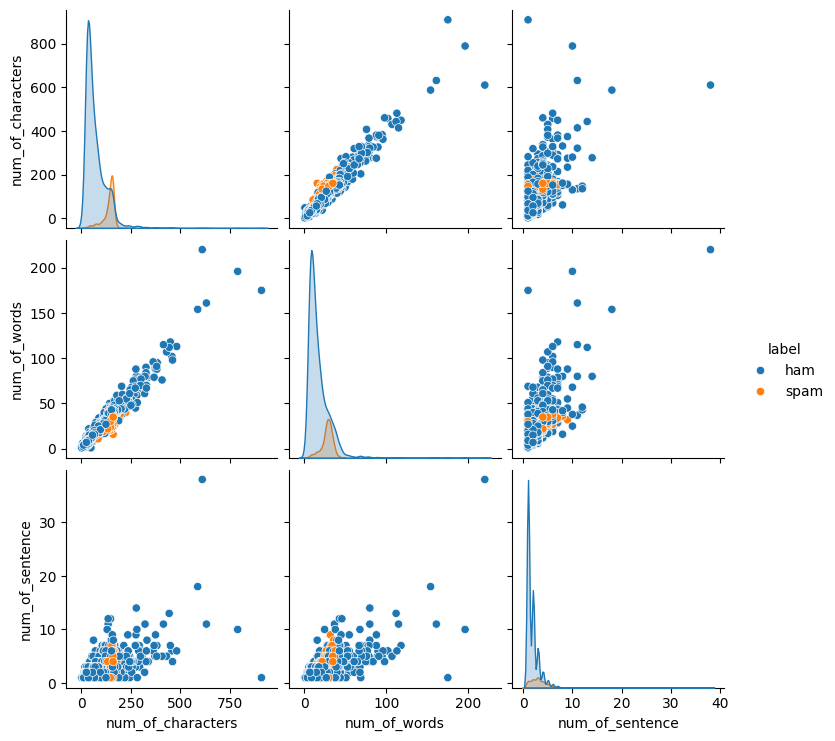

In [20]:
sns.pairplot(data=df,hue ="label")
plt.show()

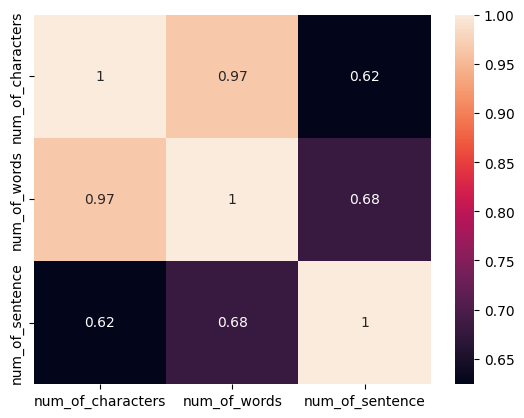

In [21]:
sns.heatmap(df.select_dtypes(include=["int64","float64"]).corr(),annot = True)
plt.show()

In [22]:
X = df["text"].values
y = df["label"].values

# Encode labels (ham=0, spam=1)
le = LabelEncoder()
y = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [23]:
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 4135
Testing samples: 1034


In [24]:
# Example: glove.6B.100d.txt
embedding_dim = 100
glove_path = "glove.6B.100d.txt"

# Load GloVe embeddings
embeddings_index = {}
with open(glove_path, "r", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = vector

In [25]:
def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return text.split()

# Build vocabulary
vocab = Counter()
for sentence in X_train:
    vocab.update(tokenize(sentence))

# Map words to indices
word2idx = {word: idx+2 for idx, (word, _) in enumerate(vocab.items())}
word2idx["<PAD>"] = 0
word2idx["<UNK>"] = 1
idx2word = {idx: word for word, idx in word2idx.items()}

vocab_size = len(word2idx)
print("Vocabulary size:", vocab_size)

Vocabulary size: 7398


In [26]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in word2idx.items():
    vector = embeddings_index.get(word)
    if vector is not None:
        embedding_matrix[idx] = vector
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))
print("Embedding matrix shape:", embedding_matrix.shape)

Embedding matrix shape: (7398, 100)


In [27]:
def encode_sentence(sentence, word2idx, max_len=30):
    tokens = tokenize(sentence)
    ids = [word2idx.get(w, word2idx["<UNK>"]) for w in tokens]
    if len(ids) < max_len:
        ids += [word2idx["<PAD>"]] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

class TextDataset(Dataset):
    def __init__(self, X, y, word2idx, max_len=30):
        self.X = [encode_sentence(text, word2idx, max_len) for text in X]
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

train_data = TextDataset(X_train, y_train, word2idx)
test_data = TextDataset(X_test, y_test, word2idx)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

In [28]:
class SentimentNN_GloVe(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix):
        super(SentimentNN_GloVe, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.tensor(embedding_matrix))
        self.embedding.weight.requires_grad = False  # freeze GloVe embeddings

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        out = self.dropout(hidden[-1])
        out = self.fc(out)
        return out


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SentimentNN_GloVe(vocab_size, embedding_dim, 128, 2, embedding_matrix).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [30]:
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in tqdm(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")


100%|██████████| 130/130 [00:00<00:00, 180.94it/s]


Epoch 1/10, Loss: 0.3603


100%|██████████| 130/130 [00:00<00:00, 195.43it/s]


Epoch 2/10, Loss: 0.3282


100%|██████████| 130/130 [00:00<00:00, 197.01it/s]


Epoch 3/10, Loss: 0.3437


100%|██████████| 130/130 [00:00<00:00, 202.91it/s]


Epoch 4/10, Loss: 0.2098


100%|██████████| 130/130 [00:00<00:00, 217.60it/s]


Epoch 5/10, Loss: 0.1588


100%|██████████| 130/130 [00:00<00:00, 222.66it/s]


Epoch 6/10, Loss: 0.1452


100%|██████████| 130/130 [00:00<00:00, 217.91it/s]


Epoch 7/10, Loss: 0.1228


100%|██████████| 130/130 [00:00<00:00, 197.33it/s]


Epoch 8/10, Loss: 0.1121


100%|██████████| 130/130 [00:00<00:00, 215.43it/s]


Epoch 9/10, Loss: 0.0967


100%|██████████| 130/130 [00:00<00:00, 208.82it/s]

Epoch 10/10, Loss: 0.0888


In [31]:
model.eval()
correct = 0
total = 0

y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
        y_pred.extend(preds.cpu().numpy())

print(f"Test Accuracy: {correct / total:.4f}")

Test Accuracy: 0.9691


Accuracy: 0.9690522243713733
Precision: 0.9159663865546218
Recall: 0.8320610687022901
F1-score: 0.872


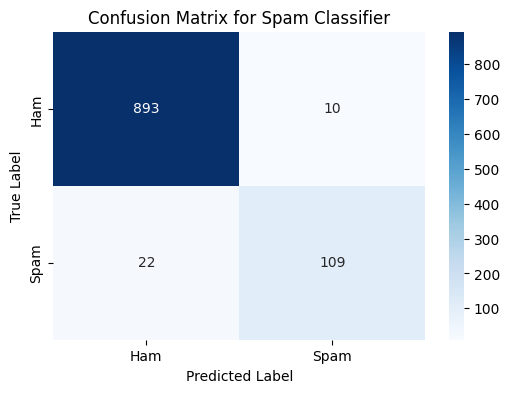

In [32]:
# Convert y_test to numpy
y_true = y_test
cm = confusion_matrix(y_true, y_pred)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1-score:", f1_score(y_true, y_pred))

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Spam Classifier')
plt.show()

In [33]:
# Save model
torch.save(model.state_dict(), "spam_model_glove.pth")

# If you used a tokenizer
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenize, f)

In [34]:
def predict_text(model, text, word2idx, max_len=30):
    model.eval()
    with torch.no_grad():
        # Encode input
        encoded = encode_sentence(text, word2idx, max_len)
        input_tensor = torch.tensor(encoded).unsqueeze(0).to(device)  # shape: [1, max_len]
        
        # Predict
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()
        
        # Convert label to text
        label = le.inverse_transform([pred])[0]
        
        return label


In [35]:
test_msgs = [
    "Congratulations! You've won a $1000 Walmart gift card. Click here to claim your prize.",
    "Hey, are we still meeting for lunch today?",
    "Free entry in a weekly competition to win tickets! Text WIN to 80085 now!"
]

for msg in test_msgs:
    print(f"Message: {msg}")
    print(f"Prediction: {predict_text(model, msg, word2idx)}")
    print("-" * 60)


Message: Congratulations! You've won a $1000 Walmart gift card. Click here to claim your prize.
Prediction: spam
------------------------------------------------------------
Message: Hey, are we still meeting for lunch today?
Prediction: ham
------------------------------------------------------------
Message: Free entry in a weekly competition to win tickets! Text WIN to 80085 now!
Prediction: spam
------------------------------------------------------------


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Rebuild model
model = SentimentNN_GloVe(vocab_size, embedding_dim, 128, 2, embedding_matrix)
model.load_state_dict(torch.load("spam_model_glove.pth", map_location=device))
model.to(device)
model.eval()

# Label encoder
le = LabelEncoder()
le.fit(["ham", "spam"])  # must match original encoding

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15060\3211382885.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("spam_model_glove.pth", ma

LabelEncoder()

In [37]:
def clean_filename(text):
    # Replace invalid filename characters
    return re.sub(r'[\\/*?:"<>|]', "", text)

def getEmails():
    creds = None
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)

    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('gmail', 'v1', credentials=creds)
    result = service.users().messages().list(userId='me', maxResults=20).execute()
    messages = result.get('messages', [])

    os.makedirs("spam_emails", exist_ok=True)
    os.makedirs("ham_emails", exist_ok=True)

    for msg in messages:
        txt = service.users().messages().get(userId='me', id=msg['id']).execute()

        try:
            payload = txt['payload']
            headers = payload['headers']

            subject = sender = "(Unknown)"
            for d in headers:
                if d['name'] == 'Subject':
                    subject = d['value']
                if d['name'] == 'From':
                    sender = d['value']

            parts = payload.get('parts')
            if parts:
                data = parts[0]['body'].get('data')
                if data:
                    data = data.replace("-", "+").replace("_", "/")
                    decoded_data = base64.b64decode(data)
                    soup = BeautifulSoup(decoded_data, "lxml")
                    body = soup.get_text()
                else:
                    body = ""
            else:
                body = ""

            # Combine subject and body for classification
            full_text = f"{subject}\n{body}"
            label = predict_text(model, full_text, word2idx)

            print(f"From: {sender}")
            print(f"Subject: {subject}")
            print(f"Prediction: {label}\n")

            # Save message to corresponding folder
            filename = clean_filename(subject[:50]) or "no_subject"
            filepath = os.path.join(f"{label}_emails", f"{filename}.txt")

            with open(filepath, "w", encoding="utf-8") as f:
                f.write(f"From: {sender}\n")
                f.write(f"Subject: {subject}\n\n")
                f.write(body)

        except Exception as e:
            print(f"Error processing message: {e}")
            continue


In [ ]:
getEmails()

In [ ]:
# Schedule job every 6 hours
schedule.every(6).hours.do(getEmails)

print("Scheduler started.\n")

def countdown(next_run_time):
    while datetime.now() < next_run_time:
        remaining = next_run_time - datetime.now()
        hours, remainder = divmod(remaining.seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        print(f"\rNext check in: {hours:02d}:{minutes:02d}:{seconds:02d}", end="")
        time.sleep(1)

while True:
    schedule.run_pending()
    
    next_run = schedule.next_run()
    if next_run:
        countdown(next_run)
        print()
    else:
        time.sleep(1)